In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from collections import deque
import matplotlib.pyplot as plt
from Grouping import *
import warnings
warnings.filterwarnings(action='ignore')

# RL (Wolpertinger)

In [2]:
def RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf_param):
    def zipf(VN, P, n):
        return np.random.choice(VN, n, False, P)

    class A2C_Agent:
        def __init__(self, state_size, action_size, batch_size):
            global advantages
            self.state_size = state_size
            self.action_size = action_size
            self.value_size = 1
            self.batch_size = batch_size
            advantages = np.zeros((self.batch_size, self.action_size))

            self.discount_factor = 0.9
            self.actor_lr = 0.001
            self.critic_lr = 0.01

            self.main_actor = self.build_actor()
            self.target_actor = self.build_actor()
            self.target_actor.set_weights(self.main_actor.get_weights())
            self.main_critic = self.build_critic()
            self.target_critic = self.build_critic()
            self.target_critic.set_weights(self.main_critic.get_weights())

        def score_func_loss(self, Y, action_pred):
            global advantages
            log_lik = -Y * tf.math.log(action_pred)
            log_lik_adv = log_lik * advantages
            loss = tf.reduce_mean(tf.reduce_sum(log_lik_adv, axis=1))
            return loss

        def build_actor(self):
            actor = tf.keras.models.Sequential()
            actor.add(Dense(self.state_size, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            actor.add(Dense(self.action_size, activation='softmax',kernel_initializer='he_uniform'))
            actor.compile(loss=self.score_func_loss, optimizer=tf.keras.optimizers.Adam(lr=self.actor_lr))
            return actor

        def build_critic(self):
            critic = tf.keras.models.Sequential()
            critic.add(Dense(self.state_size, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            critic.add(Dense(self.value_size, activation='linear',kernel_initializer='he_uniform'))
            critic.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=self.critic_lr))
            return critic

        def train_model(self, state_batch, reward_batch, target_train):
            global advantages
            states = np.vstack([x[0] for x in state_batch])
            actions = np.array([x[1] for x in state_batch])
            next_states = np.vstack([x[2] for x in state_batch])
            rewards = np.vstack([x for x in reward_batch])

            target = np.zeros((self.batch_size, self.value_size))
            advantages = np.zeros((self.batch_size, self.action_size))

            value = self.main_critic.predict(states)
            next_value = self.target_critic.predict(next_states)

            target = rewards + self.discount_factor * next_value
            advantages[range(self.batch_size), actions] = np.reshape(target - value, self.batch_size)

            self.main_actor.fit(states, advantages, epochs=1, verbose=0)
            self.main_critic.fit(states, target, epochs=1, verbose=0)

            if target_train:
                self.target_actor.set_weights(self.main_actor.get_weights())
                self.target_critic.set_weights(self.main_critic.get_weights())

    class cache_env:
        def __init__(self, VN, cs, s_len, l_len, K, a=1):
            self.VN = VN
            self.cs = cs
            self.K = K
            self.s_len = s_len
            self.l_len = l_len
            self.s_buffer = []
            self.l_buffer = []
            self.s_cnt = np.zeros(VN)
            self.l_cnt = np.zeros(VN)
            self.a = a
            self.P = np.array([1/(i**self.a) for i in range(1, self.VN+1)])
            self.P /= sum(self.P)
            np.random.shuffle(self.P)
            self.state = []
            self.rq = zipf(self.VN, self.P, 1)
            self.count()

        def step(self, a):
            rq = list(self.rq)
            prev_state = np.hstack((self.s_cnt[rq + self.state], self.l_cnt[rq + self.state]))
            states = None
            if a == 'pass':
                pass
            elif a == 'append':
                self.state.append(self.rq[0])
            else:
                states = [copy.deepcopy(self.state) for _ in range(K)]
                for i in range(K):
                    if a[i] == 0:
                        continue
                    states[i].remove(states[i][a[i]-1])
                    states[i].append(self.rq[0])
            self.rq = zipf(self.VN, self.P, 1)
            self.count()
            return prev_state, states
        
        def count(self):
            if sum(self.s_cnt) == self.s_len:
                self.s_cnt[self.s_buffer[0]] -= 1
                self.s_buffer = self.s_buffer[1:]
            self.s_cnt[self.rq] += 1
            self.s_buffer.append(self.rq[0])
            if sum(self.l_cnt) == self.l_len:
                self.l_cnt[self.l_buffer[0]] -= 1
                self.l_buffer = self.l_buffer[1:]
            self.l_cnt[self.rq] += 1
            self.l_buffer.append(self.rq[0])
            

    state_size = 2 * (cache_size + 1)
    action_size = cache_size + 1
    target_update_fre = 10
    
    memory_size = 50
    state_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    reward_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    batch_size = 10

    reward_list = []
    
    with tf.Graph().as_default():
        Agents = [A2C_Agent(state_size, action_size, batch_size) for _ in range(num_of_client)]
        cache = [cache_env(num_of_video, cache_size, s_len, l_len, K, zipf_param) for _ in range(num_of_client)]
        for i in range(N):
            Train = np.zeros(num_of_client)
            for n in range(num_of_client):
                if np.random.rand() < ch_p:
                    new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                    new_P /= sum(new_P)
                    np.random.shuffle(new_P)
                    cache[n].P = rho * cache[n].P + (1-rho) * new_P
                    
                if cache[n].rq in cache[n].state:
                    prev_state = cache[n].step('pass')
                elif len(cache[n].state) < cache[n].cs:
                    prev_state = cache[n].step('append')
                else:
                    Train[n] = 1
                    rq = list(cache[n].rq)
                    state = np.hstack((cache[n].s_cnt[rq + cache[n].state], cache[n].l_cnt[rq + cache[n].state]))

                    pred = Agents[n].main_actor.predict(np.array([state]))[0]
                    a_list = np.random.choice(action_size, K, False, p = pred)

                    prev_state, states = cache[n].step(a_list)
                    rq = list(cache[n].rq)
                    state_list = [np.hstack((cache[n].s_cnt[rq + states[i]], cache[n].l_cnt[rq + states[i]])) for i in range(K)]
                    critics = Agents[n].main_critic.predict(np.vstack(state_list))
                    idx = np.where(critics == max(critics))[0][0]
                    a = a_list[idx]
                    cache[n].state = states[idx]
                    
                    state = state_list[idx]
                    state_memory[n].append((prev_state, a, state))

            rqs = np.array([cache[i].rq for i in range(num_of_client)])
            caches = [cache[i].state for i in range(num_of_client)]
            cn, rq, ch = Local(rqs, caches)
            cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
            connection = len(cn)
            reward = np.zeros(num_of_client)
            local = np.ones(num_of_client)
            for c in cn:
                if len(c) > 1:
                    for i in c:
                        reward[i] = 0.5
                        local[i] = 0
                else:
                    local[c[0]] = 0
            reward = reward + local
            
            reward_list.append(sum(reward)/num_of_client)
            
            for n in range(num_of_client):
                if Train[n]:
                    reward_memory[n].append(reward[n])
                    if len(reward_memory[n]) >= batch_size:
                        batch = np.random.choice(len(reward_memory[n]), min(len(reward_memory[n]), batch_size), False)
                        state_batch = np.array(state_memory[n])[batch]
                        reward_batch = np.array(reward_memory[n])[batch]
                        Agents[n].train_model(state_batch, reward_batch, (i+1) % target_update_fre == 0)
            
    return reward_list

# Graph

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


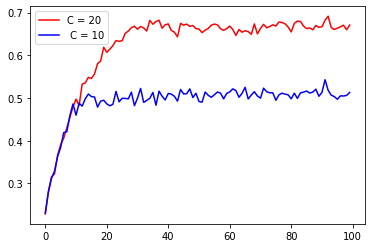

In [3]:
M = 30
N = 100
num_of_video = 100
num_of_client = 50
cache_size = 20
zipf_param = 1
s_len = 10
l_len = 100
K = 5
ch_p = 0.001
rho = 0.5

t = [n for n in range(N)]
mean_reward1 = np.zeros(N)
mean_reward2 = np.zeros(N)

for i in range(M):
    reward_list = np.array(RL_Caching(M, N, num_of_video, num_of_client, cache_size, s_len, l_len, K, zipf_param))
    mean_reward1 += reward_list / M
    if i == 0:
        max_list1 = reward_list
        min_list1 = reward_list
    else:
        max_list1 = [max(max_list1[i], reward_list[i]) for i in t]
        min_list1 = [min(min_list1[i], reward_list[i]) for i in t]

    reward_list = np.array(RL_Caching(M, N, num_of_video, num_of_client, cache_size//2, s_len, l_len, K, zipf_param))
    mean_reward2 += reward_list / M
    if i == 0:
        max_list2 = reward_list
        min_list2 = reward_list
    else:
        max_list2 = [max(max_list2[i], reward_list[i]) for i in t]
        min_list2 = [min(min_list2[i], reward_list[i]) for i in t]
        
plt.plot(t, mean_reward1, 'r')
plt.plot(t, mean_reward2, 'b')
plt.legend(['C = 20','C = 10'])
plt.show()

In [4]:
print(list(mean_reward1))

[0.22866666666666668, 0.2810000000000001, 0.3153333333333333, 0.3223333333333334, 0.366, 0.3913333333333333, 0.40599999999999997, 0.4299999999999999, 0.45433333333333326, 0.4789999999999999, 0.49733333333333307, 0.4823333333333333, 0.5326666666666667, 0.5353333333333333, 0.5483333333333333, 0.5456666666666665, 0.556, 0.5803333333333335, 0.5866666666666667, 0.6186666666666666, 0.607, 0.6143333333333334, 0.6226666666666667, 0.6343333333333334, 0.6326666666666667, 0.6339999999999999, 0.6513333333333332, 0.6566666666666667, 0.6646666666666666, 0.668, 0.6610000000000001, 0.6673333333333332, 0.6640000000000001, 0.6566666666666666, 0.6816666666666669, 0.6726666666666667, 0.6789999999999998, 0.6819999999999999, 0.6633333333333333, 0.6713333333333333, 0.6733333333333333, 0.6579999999999999, 0.654, 0.643, 0.6746666666666664, 0.6703333333333332, 0.673, 0.6676666666666666, 0.6696666666666665, 0.6623333333333333, 0.6613333333333332, 0.653, 0.6586666666666668, 0.6629999999999999, 0.6703333333333334,

In [5]:
print(max_list1)

[0.32, 0.4, 0.4, 0.47, 0.47, 0.5, 0.52, 0.52, 0.58, 0.57, 0.64, 0.58, 0.64, 0.65, 0.66, 0.62, 0.66, 0.69, 0.7, 0.7, 0.7, 0.76, 0.7, 0.74, 0.8, 0.72, 0.74, 0.74, 0.76, 0.78, 0.78, 0.76, 0.74, 0.77, 0.76, 0.78, 0.78, 0.78, 0.76, 0.76, 0.78, 0.74, 0.73, 0.75, 0.75, 0.76, 0.76, 0.78, 0.76, 0.8, 0.74, 0.76, 0.73, 0.76, 0.76, 0.75, 0.77, 0.76, 0.76, 0.76, 0.78, 0.72, 0.76, 0.72, 0.76, 0.76, 0.78, 0.74, 0.78, 0.75, 0.8, 0.76, 0.74, 0.76, 0.77, 0.76, 0.78, 0.8, 0.74, 0.79, 0.78, 0.76, 0.75, 0.79, 0.76, 0.76, 0.75, 0.74, 0.76, 0.76, 0.78, 0.78, 0.78, 0.81, 0.78, 0.78, 0.78, 0.76, 0.76, 0.74]


In [6]:
print(min_list1)

[0.14, 0.12, 0.23, 0.24, 0.28, 0.26, 0.28, 0.29, 0.35, 0.38, 0.37, 0.36, 0.42, 0.43, 0.42, 0.42, 0.48, 0.48, 0.44, 0.55, 0.46, 0.49, 0.5, 0.54, 0.52, 0.52, 0.58, 0.56, 0.55, 0.6, 0.56, 0.56, 0.6, 0.57, 0.6, 0.56, 0.59, 0.56, 0.56, 0.6, 0.57, 0.54, 0.55, 0.57, 0.59, 0.6, 0.54, 0.61, 0.56, 0.56, 0.54, 0.51, 0.54, 0.55, 0.58, 0.58, 0.6, 0.59, 0.56, 0.57, 0.56, 0.57, 0.55, 0.58, 0.55, 0.5, 0.53, 0.52, 0.56, 0.52, 0.52, 0.59, 0.57, 0.56, 0.53, 0.56, 0.56, 0.56, 0.56, 0.58, 0.53, 0.58, 0.58, 0.62, 0.55, 0.56, 0.54, 0.6, 0.56, 0.56, 0.54, 0.57, 0.59, 0.55, 0.54, 0.56, 0.54, 0.52, 0.56, 0.58]


In [7]:
print(list(mean_reward2))

[0.23066666666666666, 0.2793333333333333, 0.31133333333333335, 0.3289999999999999, 0.36300000000000004, 0.3843333333333333, 0.4190000000000001, 0.42100000000000004, 0.4589999999999999, 0.486, 0.4596666666666666, 0.48766666666666664, 0.48099999999999987, 0.498, 0.5093333333333334, 0.5033333333333333, 0.5023333333333333, 0.47866666666666663, 0.49266666666666664, 0.4946666666666667, 0.48633333333333334, 0.48166666666666663, 0.48533333333333334, 0.5153333333333331, 0.491, 0.4993333333333333, 0.49899999999999994, 0.49800000000000005, 0.5136666666666666, 0.4819999999999999, 0.4999999999999999, 0.5223333333333332, 0.48966666666666664, 0.49433333333333324, 0.49933333333333335, 0.5129999999999999, 0.483, 0.5159999999999999, 0.5040000000000001, 0.49533333333333335, 0.5106666666666667, 0.509, 0.504, 0.4926666666666667, 0.52, 0.5093333333333332, 0.5099999999999999, 0.5213333333333331, 0.5009999999999999, 0.511, 0.4916666666666666, 0.4903333333333333, 0.514, 0.5063333333333332, 0.5016666666666667, 

In [8]:
print(max_list2)

[0.32, 0.35, 0.4, 0.43, 0.5, 0.47, 0.51, 0.54, 0.58, 0.58, 0.52, 0.59, 0.58, 0.61, 0.64, 0.6, 0.62, 0.55, 0.59, 0.58, 0.6, 0.58, 0.59, 0.62, 0.56, 0.64, 0.66, 0.63, 0.62, 0.58, 0.62, 0.63, 0.62, 0.62, 0.6, 0.62, 0.64, 0.6, 0.62, 0.6, 0.59, 0.62, 0.58, 0.57, 0.6, 0.61, 0.66, 0.64, 0.64, 0.62, 0.6, 0.6, 0.58, 0.62, 0.64, 0.62, 0.61, 0.6, 0.6, 0.63, 0.64, 0.58, 0.61, 0.64, 0.6, 0.66, 0.63, 0.6, 0.61, 0.58, 0.59, 0.64, 0.65, 0.64, 0.6, 0.59, 0.64, 0.64, 0.59, 0.62, 0.62, 0.62, 0.58, 0.58, 0.6, 0.64, 0.62, 0.6, 0.62, 0.64, 0.66, 0.66, 0.64, 0.6, 0.68, 0.6, 0.65, 0.6, 0.64, 0.66]


In [9]:
print(min_list2)

[0.14, 0.15, 0.19, 0.26, 0.3, 0.31, 0.28, 0.28, 0.38, 0.4, 0.32, 0.4, 0.39, 0.39, 0.42, 0.4, 0.38, 0.35, 0.37, 0.39, 0.38, 0.4, 0.36, 0.4, 0.4, 0.4, 0.37, 0.38, 0.42, 0.38, 0.4, 0.43, 0.37, 0.34, 0.38, 0.41, 0.38, 0.42, 0.38, 0.31, 0.42, 0.42, 0.42, 0.36, 0.43, 0.4, 0.39, 0.44, 0.38, 0.4, 0.4, 0.33, 0.39, 0.37, 0.39, 0.4, 0.36, 0.4, 0.42, 0.4, 0.38, 0.44, 0.43, 0.4, 0.44, 0.44, 0.38, 0.4, 0.38, 0.42, 0.38, 0.43, 0.42, 0.4, 0.39, 0.4, 0.4, 0.36, 0.4, 0.38, 0.35, 0.35, 0.39, 0.4, 0.44, 0.37, 0.34, 0.37, 0.4, 0.41, 0.4, 0.42, 0.42, 0.42, 0.39, 0.4, 0.41, 0.42, 0.38, 0.42]
